In [1]:
import pandas as pd
import numpy as np
import logging
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from matplotlib import dates, rcParams, cycler
from matplotlib.ticker import FuncFormatter, ScalarFormatter
from data_processing import ProcessData

# shh...
logging.getLogger().setLevel('INFO')

# dark theme
plt.style.use('dark_background')

# Set the default styles
color = ['#e84118', 'orange', 'purple', 'green', 'blue',]
# rcParams['axes.prop_cycle'] = cycler(color=color) 
# rcParams['axes.facecolor'] = '2f3440'
# rcParams['figure.facecolor'] = '1a1d24'
# rcParams['savefig.facecolor'] = '1a1d24'
rcParams.update({'axes.prop_cycle':     cycler(color=color),
                 'savefig.facecolor':   '1a1d24',
                 'figure.facecolor':    '1a1d24',
                 'axes.facecolor':      '2f3440',
                 'figure.dpi':          600,
                 'font.size':           12,
                 })

# # To find rcParams of interest:
# the_dict={'a': [i for i in rcParams if 'dpi' in i],
#           'b': [rcParams[i] for i in rcParams if 'dpi' in i],
#           }
# pd.DataFrame(the_dict)

In [2]:
data_directory = 'data'
data_processor = ProcessData(data_directory)
data = data_processor.process()


/Users/vrutikshah/Documents/Work Related/UCSD/Winter 2023/ECE 143/Project/ece143_data_analysis_project/data_processing.py:171: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  stage_data = funds.groupby('stage').mean().sort_values(by='total_laid_off', ascending=False)


In [ ]:
# print(data)

In [ ]:
# Funding Plots
funding_data: pd.DataFrame = data['layoff_processed']['__company_funding_stage']
funding_raised_layoffs: pd.DataFrame = data['layoff_processed']['__company_funding_raised']
funding_raised_layoffs.dropna(inplace=True)

# Funds raised per Layoff by Stage
fig = plt.figure(figsize=(10, 5))
plt.bar(funding_data.index, funding_data['Funds raised per Layoff'])
plt.xlabel('Stage of Funding')
plt.ylabel('Funds raised in Millions per Layoff')
plt.title('Funds raised per Layoff by Stage of Funding')
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
plt.show()

# Stage of Funding versus average layoffs
fig = plt.figure(figsize=(10, 5))
plt.bar(funding_data.index, funding_data['total_laid_off'])
plt.xlabel('Stage of Funding')
plt.ylabel('Average Layoffs')
plt.title('Average Layoffs by Stage of Funding')
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
plt.show()

# Layoffs versus Funds Raised
fig, ax = plt.subplots(figsize=(10, 6))
plt.scatter(funding_raised_layoffs['funds_raised'], funding_raised_layoffs['total_laid_off'])
plt.xlabel('Funds Raised in Millions')
plt.ylabel('Layoffs')
plt.xscale('log')
plt.yscale('log')
ax.get_xaxis().set_major_formatter(FuncFormatter(lambda x, loc: "${:,.0f}".format(float(x) * 1e6)))
ax.get_yaxis().set_major_formatter(ScalarFormatter())
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
plt.title('Layoffs versus Funds Raised')
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
plt.show()


In [ ]:
# Number of companies having >20% layoff in each industry
high_per_industry = data['layoff_processed']['__high_per_industry']
fig = plt.figure(figsize=(13, 5))
plt.bar(high_per_industry.index, high_per_industry['number of companies'], width=0.8)
plt.xlabel('Industry')
plt.ylabel('Number of Companies')
plt.title('Number of Companies Having 20% or Higher Layoffs by Industry')
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
plt.show()


# Number of companies having >20% layoff in each country
high_per_country = data['layoff_processed']['__high_per_country']
fig = plt.figure(figsize=(13, 5))
plt.bar(high_per_country.index, high_per_country['number of companies'], width=0.8)
plt.xlabel('Country')
plt.ylabel('Number of Companies')
plt.title('Number of Companies Having 20% or Higher Layoffs by Country')
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
plt.show()

**Plot Reasons for cut**

In [ ]:
save_gif=False

# Number formatter from https://learndataanalysis.org/source-code-format-axis-label-to-thousands-and-millions-suffix-matplotlib-tutorial/
def format_number(data_value, indx):
    if data_value >= 1_000_000:
        formatter = '{:1.1f}M'.format(data_value*0.000_001)
    else:
        formatter = '{:1.0f}K'.format(data_value*0.001)
    return formatter

challenger_data = ProcessData('data/challenger_data')
challenger_data = challenger_data.process()
to_plot_reason=(challenger_data['reason']
         .sort_values(by=[max(challenger_data['reason'])],ascending=False)
         .iloc[0:5].transpose()
        #  .reset_index().set_index('index')
         .sort_index(ascending=False)
         )
# print(to_plot_reason)

p_legend=[to_plot_reason.columns[i].replace('_',' ') + ': ' + format_number(to_plot_reason.iloc[0,i],None) for i in range(len(to_plot_reason.columns))]

# Year converts to YYYY/Jan/1, however the data is for the end of year.
to_plot_reason.index=pd.to_datetime(to_plot_reason.index,format='%Y')

# interpolate for smooth curve in plot
to_plot_reason=to_plot_reason.reindex(pd.date_range(min(to_plot_reason.index),pd.to_datetime('jan 2, 2022'),freq="D"))
# so that endpoints of the plot are the values for 2022
to_plot_reason.iloc[-1]=to_plot_reason.iloc[-2] 
# Spline method drastically overshoots the data points
to_plot_reason=to_plot_reason.interpolate(method='polynomial',order=2)
to_plot_reason=to_plot_reason.reindex(pd.date_range(min(to_plot_reason.index),max(to_plot_reason.index),freq="37D"))

# Plot parameters
color = ['orange', 'green', 'blue', 'purple','red',]
fig, ax = plt.subplots(constrained_layout=True)
plt.xticks(rotation=45, ha="right", rotation_mode="anchor") #rotate the x-axis values
ax.yaxis.set_major_formatter(format_number)
ax.xaxis.set_major_formatter(dates.DateFormatter('%Y'))
plt.ylabel('Number of cuts [per year]')
plt.xlabel('Year')
plt.title('Top 5 Reasons for Job Termination at the end of 2022')

# Plot builder for animation
def build_line_chart(i=int):
    # color = ['#e84118', 'purple', 'orange', 'green', 'blue',]
    plt.legend(p_legend, loc='upper left')
    p = plt.plot(to_plot_reason[:i].index, to_plot_reason[:i].values) #note it only returns the dataset, up to the point i
    # for i in range(0,len(color)):
    #     p[i].set_color(color[i]) #set the colour of each curve


# animator takes a minute
animator = ani.FuncAnimation(fig, build_line_chart, interval = 10)
plt.ylim([0, 200000])
if save_gif:
    # PillowWriter doesn't control loop count yet. Have to modify externally
    # because  looping makes this plot useless.
    animator.save('plots/reasons.gif', dpi=300, writer=ani.PillowWriter(fps=20))
else:
    # doesn't show animation in jupyter
    plt.show()
plt.close()

In [ ]:
hiring_data=challenger_data['hiring'][2022].sort_values(ascending=False).drop('TOTAL')[0:10]
hiring_data=pd.merge(hiring_data,challenger_data['hiring'][2021],right_index=True,left_index=True)
hiring_data=hiring_data.astype(int)
industries=hiring_data.index.values
h2021=hiring_data[2021].values
h2022=hiring_data[2022].values
print(h2021)
print(industries)

In [ ]:
# New job openings
x_axis=np.arange(len(industries))
fig, ax = plt.subplots(figsize=(7,5),constrained_layout=True)
# hiring_data.plot.bar()
plt.bar(x_axis + 0.1,h2022,0.2,label='2022')
plt.bar(x_axis - 0.1,h2021,0.2,label='2021')
ax.yaxis.set_major_formatter(format_number)
plt.xlabel('Industry')
plt.ylabel('Number of New Job Openings')
plt.title('Announced Job Openings in 2022 vs 2021')
plt.xticks(x_axis, industries, rotation=45, ha="right", rotation_mode="anchor")
plt.ylim([0, 500_000])
plt.legend()
plt.show()
# Retail is 728k and 882k for 2021,2022

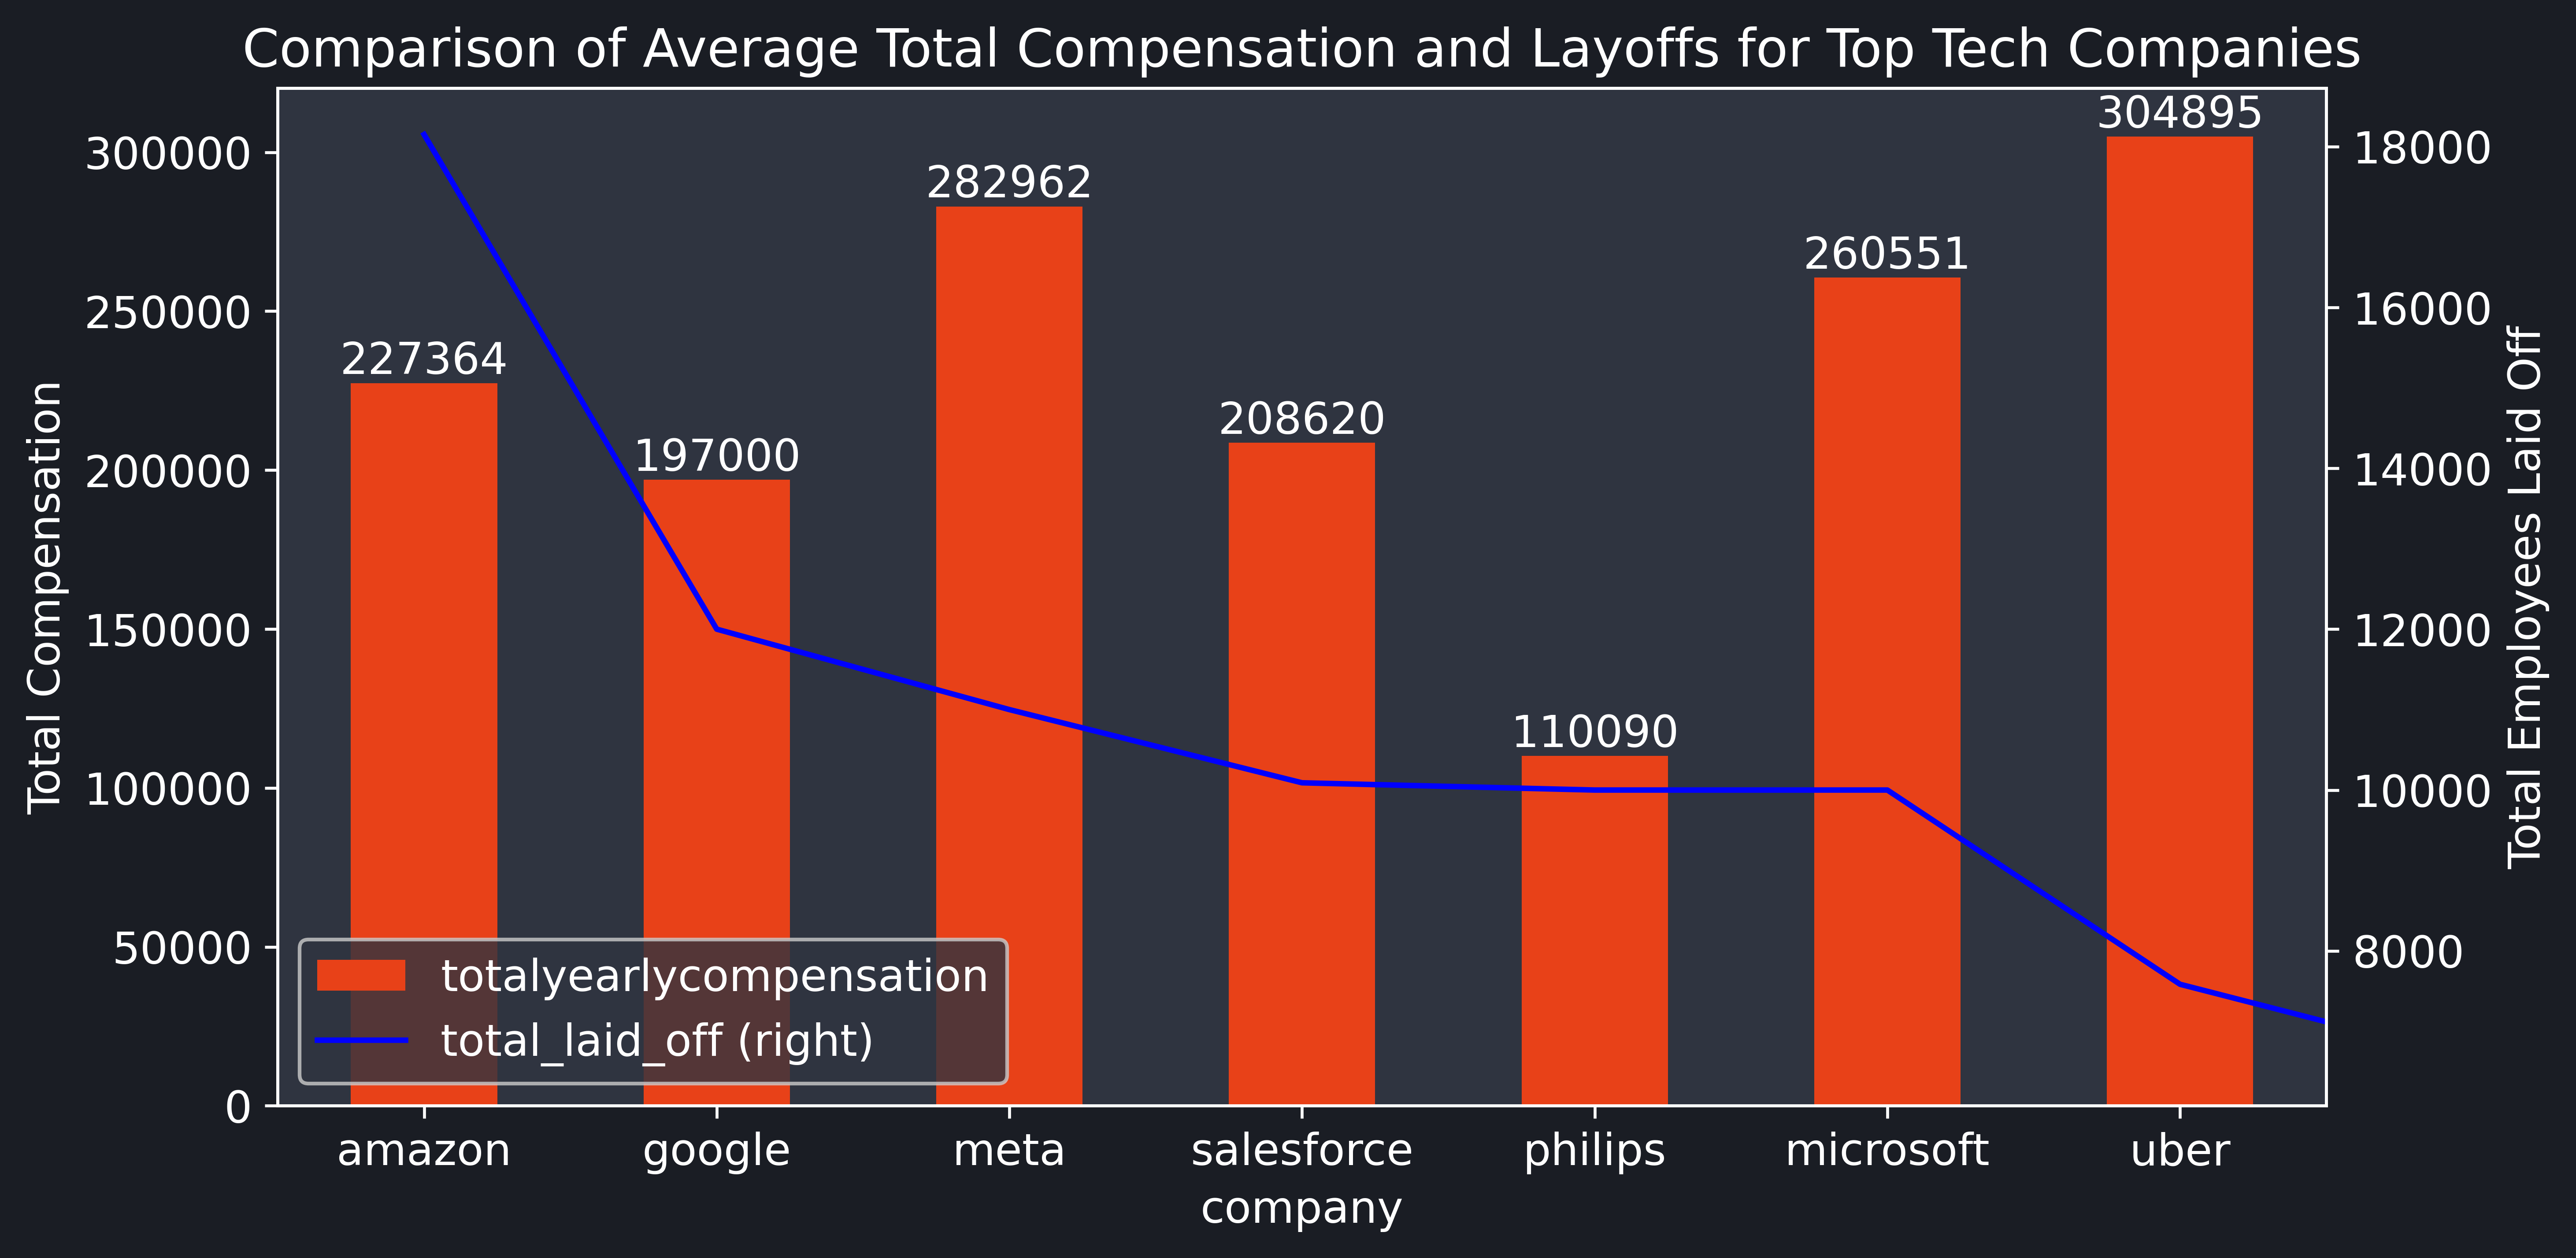

In [3]:
# Total Compensation vs Layoffs Comparison
average_compensation,top_companies_layoffs = data['salary_processed']['__company_comp_salaries']
fig,ax = plt.subplots(figsize=(10, 5))
average_compensation.plot.bar(x='company', y='totalyearlycompensation',ax=ax)
top_companies_layoffs.plot(x='company',y = 'total_laid_off',secondary_y =True,ax=ax,color='blue')
for container in ax.containers:
    ax.bar_label(container)
ax.set_ylabel('Total Compensation')
ax.right_ax.set_ylabel('Total Employees Laid Off')
plt.ylabel('Total Employees Laid Off')
plt.xlabel('Company')
plt.title('Comparison of Average Total Compensation and Layoffs for Top Tech Companies')
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax.right_ax.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2, loc='lower left')
plt.show()